# Advanced Machine Learning (MScA, 32017)

# Project Recommending Music with Audioscrobbler Data

### Yuri Balasanov, Mihail Tselishchev, &copy; iLykei 2017

## Exploring Audioscrobbler (lastfm) data

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType, StructField, DoubleType, LongType, StringType, Row
import pyspark.sql.functions as func

In [16]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark

Read data

In [17]:
# path to files
artistdata_path = './artist_data.csv'
userartist_path = './user_artist_data_train_small.csv'

In [18]:
# Schemas for both files
artistdata_struct = StructType([StructField('artistId', LongType()), \
                                StructField('name', StringType())])
userartist_struct = StructType([StructField('userId', LongType()), \
                                StructField('artistId', LongType()), \
                                StructField('count', LongType())])

In [19]:
# read artist_data file
artistdata_df = spark.read.csv(artistdata_path, sep = '\t', schema = artistdata_struct)
artistdata_df.cache() # uses MEM ONLY
artistdata_df.take(10)

[Row(artistId=2000001, name='Portishead'),
 Row(artistId=2000002, name='Air'),
 Row(artistId=2000003, name='Severed Heads'),
 Row(artistId=2000004, name='Marianne Faithfull'),
 Row(artistId=2000005, name='Peace Orchestra'),
 Row(artistId=2000006, name='Gallon Drunk'),
 Row(artistId=2000007, name='Breed'),
 Row(artistId=2000008, name='Omni Trio'),
 Row(artistId=2000009, name='The Last Poets'),
 Row(artistId=2000010, name='Rhythm & Sound')]

In [20]:
# read user_artist_data file
userartist_df = spark.read.csv(userartist_path, sep = '\t', schema = userartist_struct)
userartist_df.cache()
userartist_df.take(10)

[Row(userId=1000152, artistId=2000001, count=16),
 Row(userId=1000152, artistId=2000002, count=6),
 Row(userId=1000152, artistId=2000011, count=4),
 Row(userId=1000152, artistId=2000015, count=3),
 Row(userId=1000152, artistId=2000023, count=26),
 Row(userId=1000152, artistId=2000024, count=24),
 Row(userId=1000152, artistId=2000026, count=26),
 Row(userId=1000152, artistId=2000032, count=3),
 Row(userId=1000152, artistId=2000039, count=96),
 Row(userId=1000152, artistId=2000044, count=3)]

Summary statistics

In [21]:
# some statistics on user-artist dataframe
userartist_df.describe().show() # describe returns summary statistics for numeric columns


+-------+------------------+------------------+------------------+
|summary|            userId|          artistId|             count|
+-------+------------------+------------------+------------------+
|  count|            181733|            181733|            181733|
|   mean|1025835.7358707554| 2014691.602301178| 119.9596165803679|
| stddev|20632.986231418043|40651.215729566444|1611.7622571739207|
|    min|           1000152|           2000001|                 1|
|    max|           1098645|           2578763|            439771|
+-------+------------------+------------------+------------------+



<font color=blue>

Find 20 most popular artists.

**Hint**: Use the following methods.

`DataFrame.groupBy('cols')` - groups DataFrame using the specified columns `cols` to prepare for aggregation on them

`GroupedDataFrame.agg(exprs)` - computes aggregates and returns result as a DataFrame. Available aggregate functions are `avg`, `max`, `min`, `sum`, `count`.

Use `.join()` to add column of real names of the artists

In [22]:
# Create dataframe
salespeople=sc.parallelize(['1\tHenry\t100',
                           '2\tKaren\t100',
                           '3\tPaul\t101',
                           '4\tJimmy\t102',
                           '5\tJanice\t103']) \
.map(lambda x: x.split('\t')) \
.map(lambda x: (int(x[0]),x[1],int(x[2])))
salespeople.collect()
salespeople_df=sqlContext.createDataFrame(salespeople,['Num','Name','Store'])
print('Original DataFrame')
salespeople_df.show()

# Group the dataframe by store
salespeople_df_grouped=salespeople_df.groupBy('Store')

# Aggregate using `count`
print('Grouped and Aggregated by "count"')
salespeople_df_grouped.agg({'Store': "count"}).show()

# Alternatively, use pyspark.sql.functions as func and count group members after assigning 
# each of them literal(constant) value 1 by func.lit(1)
print('Grouped and aggregated by count after lit(1)')
salespeople_df_grouped.agg(func.count(func.lit(1)).alias('New column')).show()

# Aggregate by sum of column 'Num'
print('Grouped and aggregated by "sum" of column "Num"')
salespeople_df_grouped.agg(func.sum('Num')).show()

Original DataFrame
+---+------+-----+
|Num|  Name|Store|
+---+------+-----+
|  1| Henry|  100|
|  2| Karen|  100|
|  3|  Paul|  101|
|  4| Jimmy|  102|
|  5|Janice|  103|
+---+------+-----+

Grouped and Aggregated by "count"
+-----+------------+
|Store|count(Store)|
+-----+------------+
|  103|           1|
|  100|           2|
|  101|           1|
|  102|           1|
+-----+------------+

Grouped and aggregated by count after lit(1)
+-----+----------+
|Store|New column|
+-----+----------+
|  103|         1|
|  100|         2|
|  101|         1|
|  102|         1|
+-----+----------+

Grouped and aggregated by "sum" of column "Num"
+-----+--------+
|Store|sum(Num)|
+-----+--------+
|  103|       5|
|  100|       3|
|  101|       3|
|  102|       4|
+-----+--------+



<font color=blue>

In the following cell enter code selecting 20 most popular artists by creating DataFrame `artists` of format. Cache object `artists`.

`artists.cache() <br>

artists.orderBy("num_of_users", ascending=False).show(20)`

+--------+-----------+------------+--------------------+ <br>
|artistId|total_count|num_of_users|                name| <br>
+--------+-----------+------------+--------------------+ <br>
| 2000710|    2473963|       45178|           Radiohead| <br>
| 2003097|    1912942|       43465|           Green Day| <br>
| 2004180|    2241957|       40506|         The Beatles| <br>
| 2000842|     989287|       38102|            Coldplay| <br>
| 2000708|    1191329|       36468|             Nirvana| <br>
| 2000914|    1079743|       35704|Red Hot Chili Pep...| <br>
| 2000868|    1004762|       34516|                  U2| <br>
| 2004129|    1531912|       32018|           Metallica| <br>
| 2002433|     968130|       31611|              Weezer| <br>
| 2028381|     425530|       30988|           [unknown]| <br>
| 2127606|     734595|       30370|     Franz Ferdinand| <br>
| 2000061|    1381406|       30340|          Pink Floyd| <br>
| 2151366|     869596|       29879|         The Killers| <br>
| 2000940|     663986|       29521|   The White Stripes| <br>
| 2000249|     898207|       28888|                Beck| <br>
| 2000137|     888095|       28853|            The Cure| <br>
| 2001006|     936310|       28787|        Led Zeppelin| <br>
| 2000677|     884734|       28670|              Eminem| <br>
| 2155447|     746973|       28590|              R.E.M.| <br>
| 2000911|     731504|       28156|               Queen| <br>
+--------+-----------+------------+--------------------+ <br>
only showing top 20 rows <br>

In [28]:
# Top 20 most popular artist
# Group the dataframe by artistId
artists_grouped=userartist_df.groupBy('artistId')
# aggregate the sum of counts, which is how many times all users have played the artist
# aggregate the count of userId, which is how many users have listened to the artist
artists=artists_grouped.agg({"count":"sum", "userId":"count"})\
.withColumnRenamed('sum(count)', 'CountofPlaysPerArtist')\
.withColumnRenamed('count(userId)','CountofUsersPerArtist')
# Join grouped df with artistdata_df by artistId to get the name column    
artists_named=artists.join(artistdata_df, "artistId")
# Sort the new df by number of Users listening to Artist
artists_named.sort("CountofUsersPerArtist", ascending=False).show(20)


+--------+---------------------+---------------------+--------------------+
|artistId|CountofPlaysPerArtist|CountofUsersPerArtist|                name|
+--------+---------------------+---------------------+--------------------+
| 2000710|               272386|                  641|           Radiohead|
| 2003097|               215464|                  584|           Green Day|
| 2004180|               226094|                  578|         The Beatles|
| 2000708|               131860|                  573|             Nirvana|
| 2000842|                80399|                  541|            Coldplay|
| 2002433|                98676|                  541|              Weezer|
| 2000914|                99656|                  540|Red Hot Chili Pep...|
| 2000137|                99322|                  505|            The Cure|
| 2028381|                22950|                  499|           [unknown]|
| 2000868|                99696|                  498|                  U2|
| 2155446|  

Note that the 10-th most popular artist is *[unknown]*. It is an artifact of our dataset.

Maybe there are some other artifacts (such as websites instead of artist names)?

It might be a good idea to clean the dataset before doing deep analysis. <br>

Data in both files have been cleaned for you relative to the version available publicly.

**But some obvious problems are still there. <br>
Explore the dataset further and try to clean up the data as much as you can. <br>
It may help improving the score**.

<font color=blue>

Find top most active users. <br>
Create object `users` of the following format. <br>
Again, cache the object and show it sorted. <br>

`users.cache()

users.orderBy("num_of_artists", ascending=False).show(10)`

In [26]:
# Skipped code
# top 10 most active users
# group users df by UserId, aggregate sum of count: Total plays by user. 
# aggregate count of artistId : Total Artists per User
users=userartist_df.groupBy("UserId").agg({"count":"sum","artistId":"count"})\
    .withColumnRenamed('sum(count)','TotalPlaysPerUser') \
    .withColumnRenamed('count(artistId)','TotalArtistsPerUser') \
    .sort("TotalPlaysPerUser", ascending=False)
users.cache()
users.show(10)

+-------+-----------------+-------------------+
| UserId|TotalPlaysPerUser|TotalArtistsPerUser|
+-------+-----------------+-------------------+
|1016450|           650696|                173|
|1042101|           537000|                 41|
|1030268|           277505|                 43|
|1043655|           194279|                 82|
|1029444|           141445|                 51|
|1043832|           131238|                100|
|1012180|           122680|                339|
|1028142|           122468|                 54|
|1041585|            98357|                398|
|1027163|            88421|                139|
+-------+-----------------+-------------------+
only showing top 10 rows



In [29]:
userartist_df.orderBy("count", ascending=False).show(10)

+-------+--------+------+
| userId|artistId| count|
+-------+--------+------+
|1042101| 2003226|439771|
|1016450| 2005362|433060|
|1016450| 2022384|155895|
|1043832| 2005362|101076|
|1029444| 2009279| 89592|
|1021070| 2006922| 67548|
|1030268| 2009346| 62815|
|1030268| 2002072| 51039|
|1027163| 2000061| 36083|
|1043655| 2008227| 34800|
+-------+--------+------+
only showing top 10 rows



**Note that some users have played some artists songs enormous number of times! <br>
This is also an artifact (someone's mistake, spam-attack, etc). <br>
It seems reasonable to remove all records with large *count* value**.

<font color=blue>

Calculate sparsity coefficient of user-artist matrix defined as
$$\frac{Number~of~rows~in~data~set}{Number~of~users~\times~Number~of~artists}$$

Enter code in the following cell

`Sparsity Сoeff = 0.00010881247476449967`

In [30]:
# Skipped code
# sparsity coefficient of user-artist matrix
nrows=userartist_df.count()# :181733
nusers=userartist_df.select("UserId").distinct().count()# :999
nartists=artistdata_df.select("artistId").distinct().count() # :1428562
sparsity_coeff = nrows/(nusers*nartists) # :0.00012734128089289434
sparsity_coeff

0.00012734128089289434

<font color=blue>

Note that user-artist matrix is *very* sparse.

Plot histogram of user counts per artist. <br>

**Hint**. Create a list of user counts per artist, then create histogram similar to the example in notebook "Linear Regression in Spark MLLib" 

Enter code in the following cell.

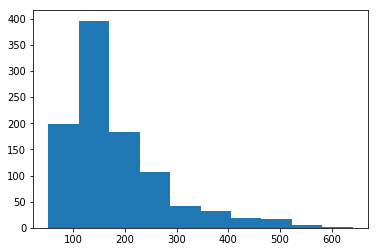

In [43]:
# Skipped code
# histogram of users per artist
import matplotlib.pyplot as plt
plt.hist(artists_named.select("CountofUsersPerArtist").toPandas().values)
plt.show()


<font color=blue>

Plot histogram of artists per user.

Enter code in the following cell.

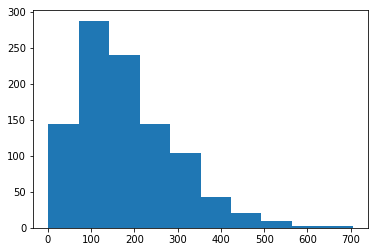

In [44]:
# Skipped code
# histogram of artists per user
plt.hist(users.select("TotalArtistsPerUser").rdd.map(lambda x:x[0]).collect())
plt.show()


Check large data set for number of users who played only very few artists and number of artists almost never played by any user. <br>
If a lot of artists have only one or two listeners that may be not good. <br>
Also if many users have only one or two played artists it may cause a problem. <br>
Should we also remove such users and artists before fitting the model?